# **Find freature in a life game**
The original paper is in https://aip.scitation.org/doi/pdf/10.1063/5.0063384

https://github.com/lantunes/cellpylib

In [1]:
!pip install cellpylib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for cellpylib: filename=cellpylib-2.3.1-py3-none-any.whl size=37202 sha256=cc33ae39584cc1cd9e5641da96ed73a7eaba8eaa0851e9ed36fc7b23b714c4bb
  Stored in directory: /root/.cache/pip/wheels/13/16/78/edab40676fff7d27f78a3da537946152ecaa29d267e82b14b8
Successfully built cellpylib


we initialize a tape of length 10000 with i.i.d. random variables, discard the first 100 steps of simulation, and run 600 more
steps that are used to estimate the probability distributions used in
all information-theoretic measures.

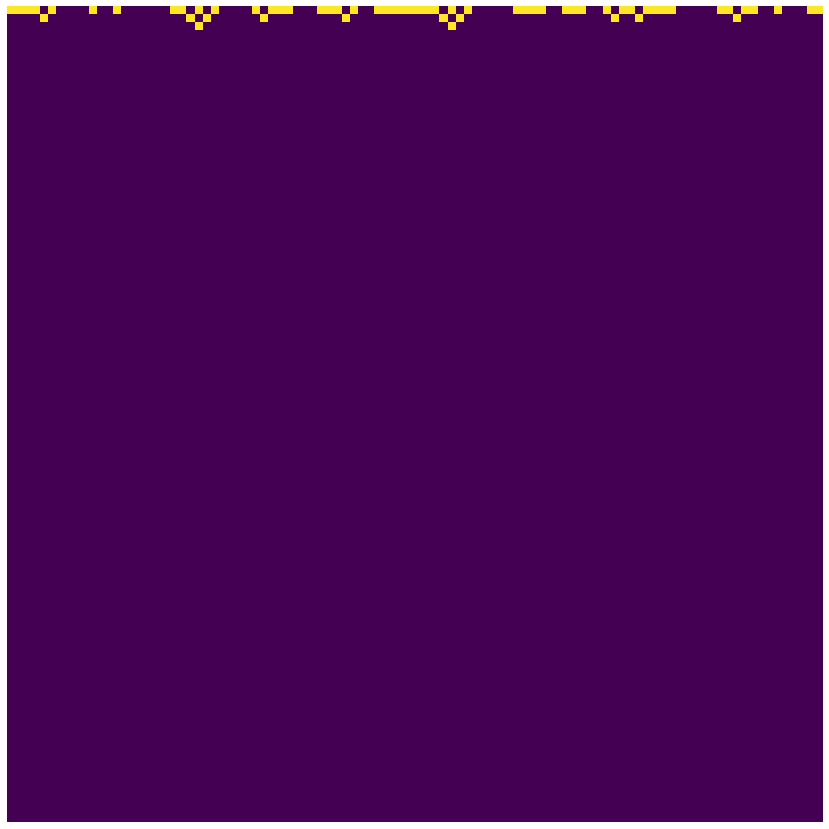

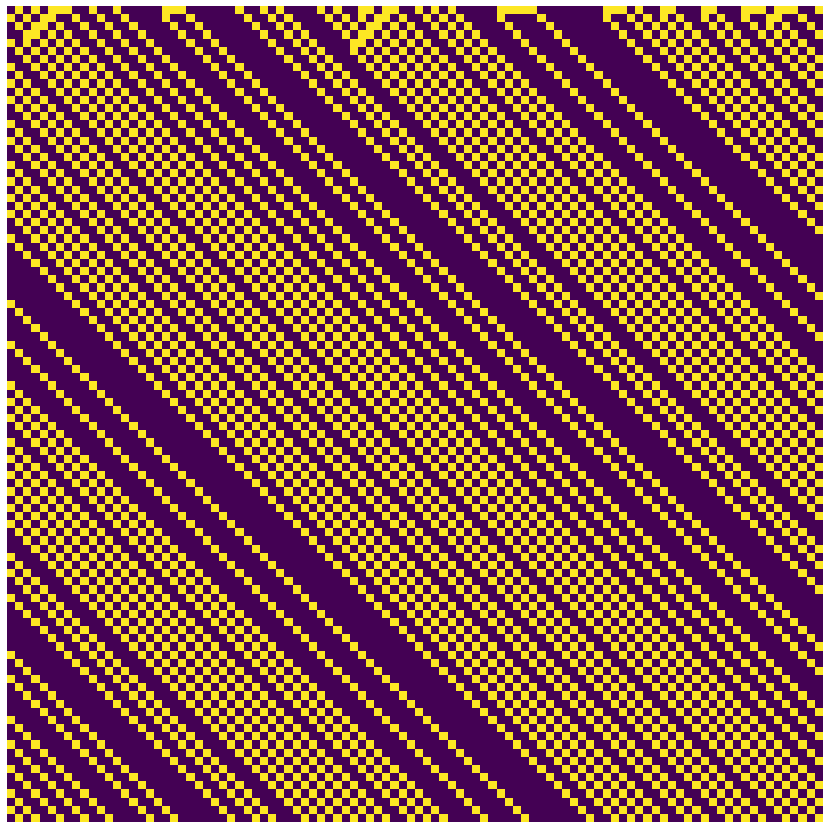

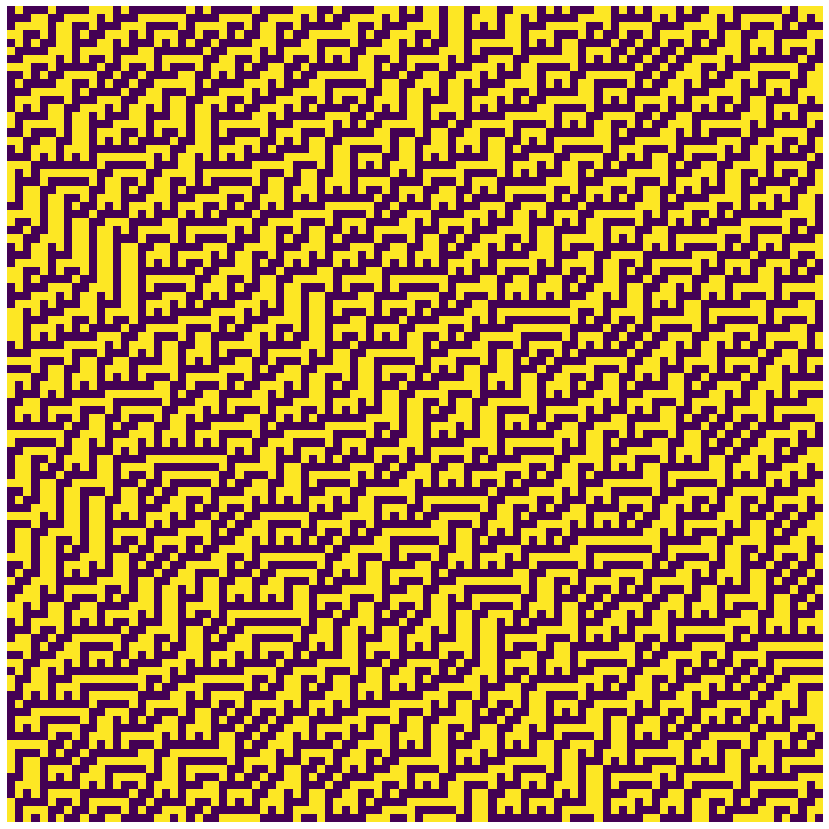

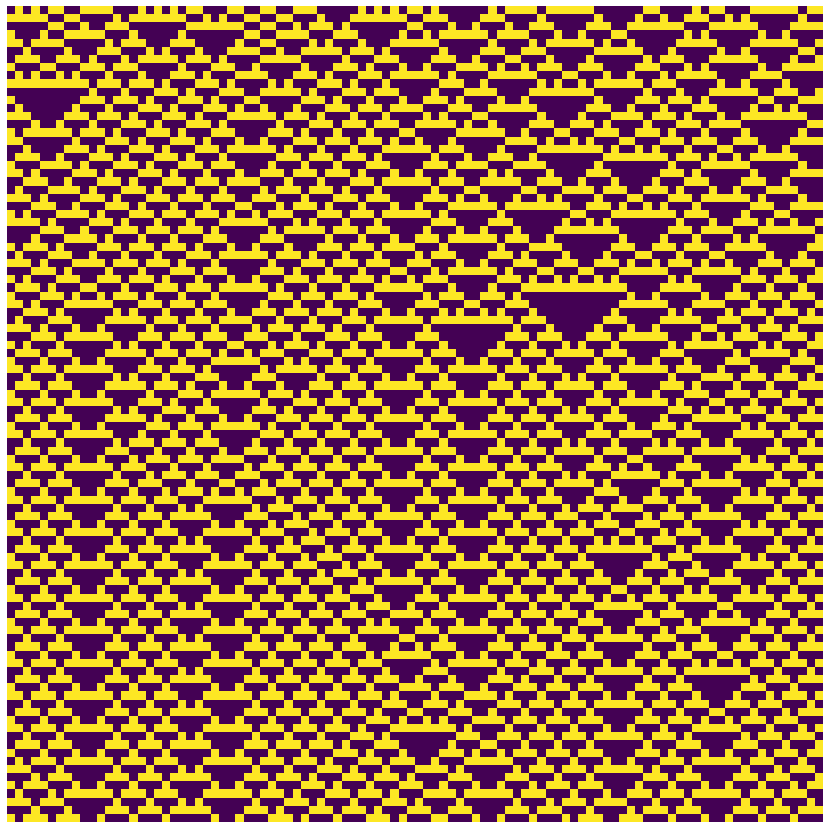

In [11]:
import numpy as np
import cellpylib as cpl
import matplotlib.pyplot as plt

rule_nums = [ 32, 56, 75, 54 ]
for rule in rule_nums:
    cellular_automaton = cpl.init_random(100, k=2)
    cellular_automaton = cpl.evolve(cellular_automaton, timesteps=100, memoize=True,
                                    apply_rule=lambda n, c, t: cpl.nks_rule(n,rule))
    cellular_automaton = np.array(cellular_automaton)
    plt.figure(figsize=(15,15))
    plt.axis("off")
    plt.imshow(cellular_automaton)
    plt.show()

avg_cell_entropy : 0.834897523285418
avg_mutual information : 0.8174009719830702


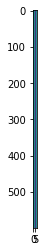

In [12]:
import numpy as np
import cellpylib as cpl
import matplotlib.pyplot as plt
import random
import copy

#parameters
dt = 1
N = 10

rule_table, actual_lambda, quiescent_state = cpl.random_rule_table(lambda_val=0.3, k=2, r=2,
                                                                   strong_quiescence=True, isotropic=True)
cellular_automaton = cpl.init_random(1000, k=2)

# use the built-in table_rule to use the generated rule table
cellular_automaton = cpl.evolve(cellular_automaton, timesteps=700,
                                apply_rule=lambda n, c, t: cpl.table_rule(n, rule_table), r=2)

# plot the resulting CA evolution
cellular_automaton = np.array(cellular_automaton)
X = cellular_automaton[100:,2*N:3*N]
plt.imshow(X)
print("avg_cell_entropy : " + str( cpl.average_cell_entropy(cellular_automaton)))
print("avg_mutual information : " + str(cpl.average_mutual_information(cellular_automaton) ))

# **Calculate $\Phi^R$**

Calc $I(X_t;X_{t - \tau}) = H( X^t ) - H( X^t | X^{t - \tau} ) $

In [13]:
from scipy.stats import entropy

def prob_distribute(state, n):
    prob_dis = [0] * (2**n)
    for i in range(len(state)):
        prob_dis[state[i]] += 1 / len(state)
    return prob_dis

def make_whole_state(hist,n):
    stnumls = np.array( [0]*len(hist) )
    for i in range(len(hist)):
        stnum = 0
        for j in range(n):
            stnum += 2**j*hist[i][j]
        stnumls[i] = stnum    
    whole_state_pr = prob_distribute(stnumls,n)
    return stnumls , whole_state_pr

# H( Xt | Xt-t )
def calc_cond_ent( whole_state , whole_state_pr , Tau ):
    cond_entropy = 0
    for i in range( len(whole_state_pr) ):
        cond_state_dis = [0] * (len(whole_state_pr))
        for j in range( len(whole_state) - int(Tau/dt) ):
            if whole_state[j] == i :
                #seek state of Tau after
                cond_state_dis[ whole_state[ j + int(Tau/dt) ] ] += 1
        if sum(cond_state_dis) != 0 :
            cond_state_pr = np.array(cond_state_dis) / sum(cond_state_dis)
            cond_entropy += whole_state_pr[i] * entropy(cond_state_pr, base=2)
    return cond_entropy

# I ( X ) = H(X) - H( Xt | Xt-t )
def Calc_Mutual_info( X , Tau ):
    whole_state, whole_state_pr = make_whole_state( X, len(X[0]) )
    Mutual_info = entropy(whole_state_pr,base = 2) - calc_cond_ent(whole_state,whole_state_pr,Tau)
    return Mutual_info

**Calculate $\Sigma_{j = 1}^{2} I(M^k_{t - \tau} ; M^k_t)$**

In [14]:
def calc_cuted_Mutual_info(X,c,Tau):
    M1 = [ [] for i in range(len(X))]
    M2 = [ [] for i in range(len(X))]
    for i in range(len(X)):
        for j in range(len(X[0])):
            if c[j] : M1[i].append(X[i][j]) 
            else :   M2[i].append(X[i][j])
    M1 = np.array(M1) ; M2 = np.array(M2)
    return Calc_Mutual_info(M1,Tau) + Calc_Mutual_info(M2,Tau)

**Find $B^{MIB} = argmin \ \frac{\phi[X;\tau,B]}{K(B)}$ when $K(B) = min\{H(M_1), H(M_2)\}$**

In [15]:
def KH(X,c):
    eps = 10**(-5)
    M1 = [ [] for i in range(len(X))]
    M2 = [ [] for i in range(len(X))]
    for i in range(len(X)):
        for j in range(len(X[0])):
            if c[j] : M1[i].append(X[i][j]) 
            else :   M2[i].append(X[i][j])
    M1 = np.array(M1) ; M2 = np.array(M2)
    _ , M1_whole_st_pr = make_whole_state(M1,len(M1[0]))
    _ , M2_whole_st_pr = make_whole_state(M2,len(M2[0]))
    return max(eps , min ( entropy(M1_whole_st_pr,base = 2) , entropy(M2_whole_st_pr,base = 2) )  )

def find_MIB(X,Tau):
    CUTS = []
    for i in range(2 ** N):
        op = [1] * N
        for j in range(N):
            if ((i >> j) & 1):
                op[N - 1 - j] = 0
        if 1<= op.count(1) and op.count(1) <= 4 : CUTS.append(op)
    
    MIB = []
    min_Mutual = 10**10
    for cut in CUTS:
        tmpM = calc_cuted_Mutual_info(X,cut,Tau) / KH(X,cut)
        if tmpM < min_Mutual :
            min_Mutual = tmpM
            MIB = copy.copy(cut)
    print(MIB)
    return MIB

$
\phi[ X ; \tau , B^{MIB}] = I(X_t;X_{t - \tau}) - \Sigma_{j = 1}^{2} I({M^{MIB}}^k_{t - \tau} ; {M^{MIB}}^k_t)
$

In [16]:
def Calc_phi(X,Tau):
    res = Calc_Mutual_info(X,Tau) - calc_cuted_Mutual_info(X,find_MIB(X,Tau),Tau)
    print(res)
    return res

In [17]:
Calc_phi(X,5)

[1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
-1.0


-1.0

what is $\lambda$ at the first place ??
According to  https://www.jstage.jst.go.jp/article/tjsai/18/6/18_6_325/_pdf



> 両隣 r個のセルの状態を考慮したセルがとりうる k 種類の状態のうち任意の一状態を選択し，それを「静状態」と呼ぶ．遷移ルールにおいて，$n_q$個の遷移がこの静状態になるとき、すなわち，λパラメータは静状態にならない確率を表している．

$$
\lambda = \frac{k^{2r+1} - n_q}{k^{2r + 1}}
$$



# **Part A**

[1, 1, 1, 1, 0]
-1.0
[1, 1, 1, 1, 0]
-1.0
[1, 1, 1, 0, 1]
-1.0
[1, 1, 1, 1, 0]
-1.0
[1, 1, 1, 1, 0]
-1.0
[1, 1, 1, 1, 0]
-1.0
[1, 1, 1, 1, 0]
-1.0
[1, 1, 1, 0, 1]
-1.0
[1, 1, 1, 0, 1]
-1.0
[1, 1, 1, 1, 0]
-1.0
[1, 1, 1, 1, 0]
-1.0
[1, 1, 1, 1, 0]
-1.0
[1, 1, 1, 1, 0]
-1.0
[1, 1, 1, 1, 0]
-1.0
[1, 1, 1, 1, 0]
-1.0
[1, 1, 1, 1, 0]
-1.0
[1, 1, 1, 1, 0]
-1.0
[1, 1, 1, 1, 0]
-1.0
[1, 1, 1, 1, 0]
-1.0
[1, 1, 1, 1, 0]
-1.0
[1, 1, 1, 0, 1]
-1.0
[1, 1, 1, 0, 1]
-1.0
[1, 1, 1, 1, 0]
-1.0
[1, 1, 1, 1, 0]
-1.0
[1, 1, 1, 1, 0]
-1.0
[1, 1, 1, 1, 0]
-1.0
[1, 1, 1, 1, 0]
-1.0
[1, 1, 1, 1, 0]
-1.0
[1, 1, 1, 0, 1]
-1.0
[1, 1, 1, 1, 0]
-1.0
[1, 1, 1, 1, 0]
0.0
[1, 1, 1, 1, 0]
0.0
[1, 1, 1, 1, 0]
0.0
[1, 1, 1, 1, 0]
0.0
[1, 1, 1, 1, 0]
0.0
[1, 1, 1, 1, 0]
0.0
[1, 1, 1, 1, 0]
0.0
[1, 1, 1, 1, 0]
0.0
[1, 1, 1, 1, 0]
0.0
[1, 1, 1, 1, 0]
0.0
[1, 1, 1, 1, 0]
0.0
[1, 1, 1, 1, 0]
0.0
[1, 1, 1, 1, 0]
0.0
[1, 1, 1, 1, 0]
0.0
[1, 1, 1, 1, 0]
0.0
[1, 1, 1, 1, 0]
0.0
[1, 1, 1, 1, 0]
0.0
[1, 1, 1, 1, 0]
0.0
[1, 1, 1, 

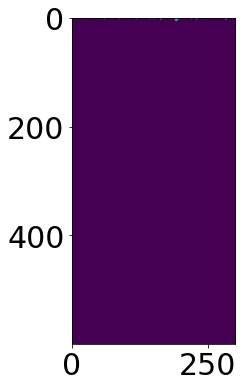

[1, 1, 0, 0, 0]
0.8932091408271299
[1, 1, 1, 0, 0]
0.8385004087004968
[1, 1, 1, 0, 0]
0.9304174206673603
[1, 1, 0, 0, 0]
0.8938781211191396
[1, 1, 1, 0, 0]
0.8633922495473576
[1, 1, 0, 0, 0]
0.8931190482110674
[1, 1, 0, 0, 0]
0.9197628834963698
[1, 1, 0, 0, 0]
0.7862767336839029
[1, 1, 1, 0, 0]
0.732909308222955
[1, 1, 0, 0, 0]
0.724645056707967
[1, 1, 0, 0, 0]
0.6525226021448536
[1, 1, 1, 0, 0]
0.6601531239376393
[1, 1, 0, 0, 0]
0.6229614607673737
[1, 1, 1, 0, 0]
0.5274178073169993
[1, 1, 1, 0, 0]
0.5229779297602903
[1, 1, 0, 0, 0]
0.5282001976519635
[1, 1, 0, 0, 0]
0.5144175765814727
[1, 1, 0, 0, 0]
0.5982514717508498
[1, 1, 1, 0, 0]
0.6456021055890548
[1, 1, 0, 0, 0]
0.5991339000724005
[1, 1, 0, 0, 0]
0.529554568637757
[1, 1, 0, 0, 0]
0.5007541360420922
[1, 1, 1, 0, 0]
0.5429010744062821
[1, 1, 0, 0, 0]
0.465935469925038
[1, 1, 0, 0, 0]
0.49012981147802726
[1, 1, 1, 0, 0]
0.5064041814712084
[1, 1, 1, 0, 0]
0.6415038180614947
[1, 1, 0, 0, 0]
0.6473853696159133
[1, 1, 1, 0, 0]
0.84387

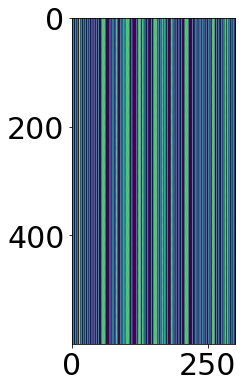

[1, 0, 0, 1, 1]
0.4147166730092553
[1, 1, 0, 0, 1]
1.1036437423446839
[1, 0, 0, 1, 1]
0.8043387728799902
[1, 0, 0, 1, 1]
0.7963006998282698
[1, 0, 0, 1, 0]
0.8686527497459977
[1, 0, 1, 1, 0]
0.36789223768709833
[1, 1, 0, 0, 0]
0.3717211744436715
[1, 0, 1, 1, 0]
0.47215009999565805
[1, 1, 0, 0, 0]
0.24284683308079558
[1, 1, 1, 0, 0]
0.42982259714849125
[1, 1, 0, 0, 1]
0.24200756498402676
[1, 1, 0, 0, 1]
0.37560695779681597
[1, 1, 0, 0, 1]
0.35355118082130654
[1, 0, 0, 1, 1]
0.41713683074955155
[1, 0, 0, 1, 0]
0.314665624750621
[1, 1, 0, 1, 0]
0.9840696734338019
[1, 1, 1, 0, 0]
0.6244427119457747
[1, 1, 0, 1, 0]
1.1993883355740194
[1, 0, 0, 1, 1]
0.9795629700260295
[1, 0, 0, 0, 1]
0.5093808338405605
[1, 1, 0, 1, 0]
0.9809820689997868
[1, 1, 0, 0, 0]
0.5480693895968272
[1, 0, 0, 1, 0]
0.40001330004998925
[1, 0, 0, 1, 1]
0.37112802598308225
[1, 1, 1, 0, 0]
0.295556252529277
[1, 1, 0, 0, 0]
0.5130031415061658
[1, 0, 0, 1, 0]
0.7216375267544259
[1, 1, 0, 0, 0]
1.0211585119999544
[1, 1, 0, 0,

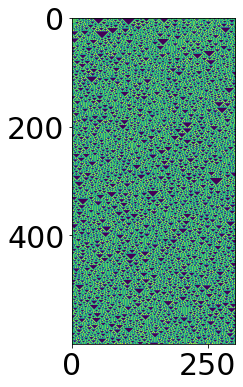

[1, 0, 1, 0, 1]
1.263305571153509
[1, 0, 1, 0, 1]
1.2129191795326957
[1, 0, 1, 0, 1]
2.0517641133129394
[1, 0, 1, 0, 1]
2.4201841094365557
[1, 0, 1, 0, 1]
1.67807904887248
[1, 0, 1, 0, 1]
2.2991141350451483
[1, 0, 1, 0, 1]
1.2301946834024347
[1, 0, 0, 1, 0]
1.6724662383318636
[1, 0, 1, 0, 1]
2.252867134864114
[1, 0, 1, 0, 1]
1.116687131823005
[1, 0, 1, 0, 1]
1.4143785013153538
[1, 0, 1, 0, 0]
1.4220719928150425
[1, 1, 0, 1, 0]
1.1695399875945347
[1, 0, 1, 0, 1]
1.2350490388806916
[1, 0, 1, 0, 1]
1.1401148356738142
[1, 1, 0, 1, 0]
1.5374500615203743
[1, 1, 0, 1, 0]
1.5190957384501678
[1, 0, 1, 0, 1]
1.1598447543146295
[1, 0, 1, 0, 1]
1.2820807271525512
[1, 0, 1, 0, 1]
1.095837458034864
[1, 1, 0, 1, 0]
1.6294901566293643
[1, 0, 1, 0, 1]
1.6726177940761815
[1, 0, 1, 0, 1]
1.1419780163924822
[1, 0, 1, 0, 1]
1.1658528525075271
[1, 0, 1, 0, 1]
1.1099973344950618
[1, 0, 1, 0, 1]
1.213988844324711
[1, 0, 1, 0, 1]
1.4202836246148245
[1, 0, 1, 0, 1]
2.2192380500814717
[1, 0, 0, 1, 1]
1.351033123

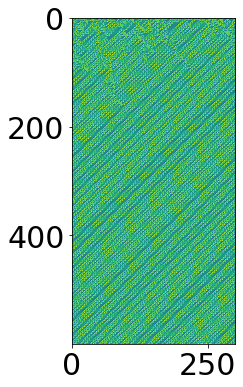

In [44]:
import cellpylib as cpl 
from statistics import stdev

# Hyper Prameters
Tau = 5
N = 5
cutting_frame = 100

rule_nums = [ 32, 56, 75, 54 ]
rules = [ [1,32,40] #36, 37, 50, 51, 54, 55, 72, 73, 76,236,
         ,[56,94,108],[18,30,126],[54,110,121] ] 
class_nums = [0, 1, 2, 3]
phi_hist = []
avmutual_hist = []
aventropy_hist = []
y_dist = []

for classnum in class_nums:
    res = []
    for rulenum in rules[classnum]:
        cellular_automaton = cpl.init_random(300, k=2)
        cellular_automaton = cpl.evolve(cellular_automaton, timesteps=600, memoize=True,
                                        apply_rule=lambda n, c, t: cpl.nks_rule(n,rulenum))
        cellular_automaton = np.array(cellular_automaton)
        #calc IIT in different space
        iitsum = 0 ; trial = 30 ;
        for i in range(trial):
            X = cellular_automaton[cutting_frame:2*cutting_frame,(i+1)*N:(i+2)*N]
            res.append( Calc_phi(X,Tau) ) 
    phi_hist.append( np.mean(res) )
    y_dist.append( stdev(res) )

    avmutual_hist.append( cpl.average_mutual_information(cellular_automaton) )
    aventropy_hist.append( cpl.average_cell_entropy(cellular_automaton) )

    plt.figure(figsize=(6,6))
    plt.imshow(cellular_automaton)
    plt.show()


Text(0, 0.5, '$\\Phi[ X ; \\tau]$')

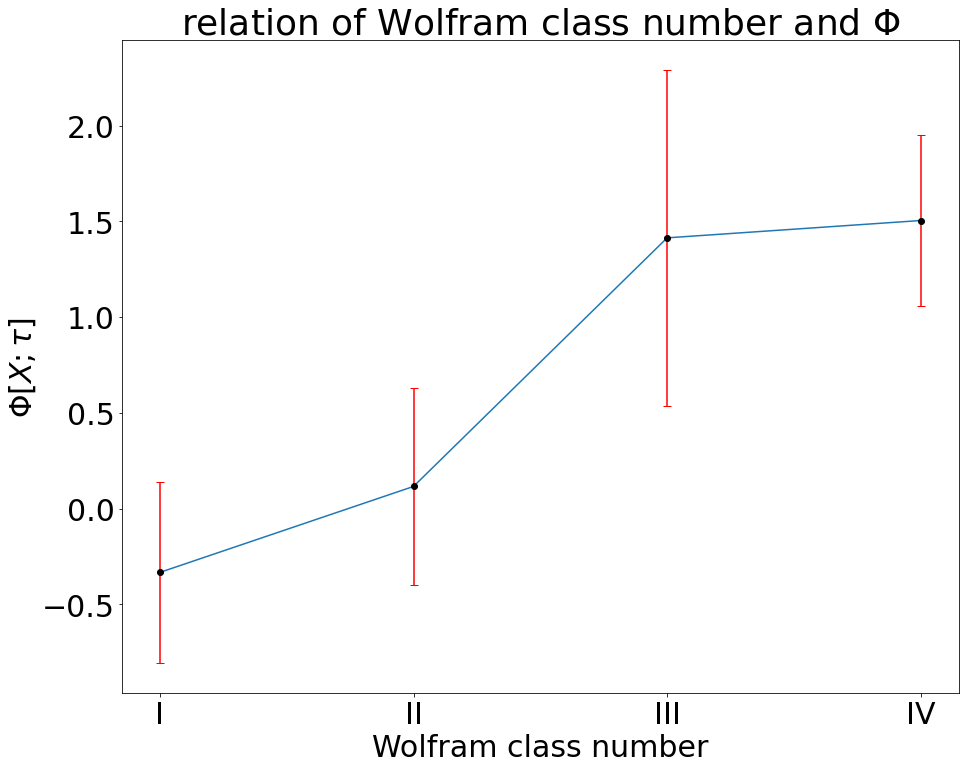

In [45]:
# plot
plt.figure(figsize=[15,12])
plt.rcParams["font.size"] = 30

plt.plot( class_nums, phi_hist, label = r'$\phi[ X ; \tau , B^{MIB}]$')
plt.errorbar(class_nums, phi_hist, yerr=y_dist, capsize=4, fmt='o', ecolor='red', color='black')
#plt.plot( class_nums, avmutual_hist,label = r'$\bar{I}$')
#plt.plot( class_nums, aventropy_hist,label = r'$\bar{H}$')
plt.xticks(class_nums, ['I', 'II', 'III', 'IV'])
plt.title( "relation of Wolfram class number" + " and "+ r"$\Phi$") # + " with " + r"$\tau$ = " +  str(Tau) )
plt.xlabel(r'Wolfram class number')
plt.ylabel(r'$\Phi[ X ; \tau]$')

In [42]:
import cellpylib as cpl 
# Hyper Prameters
Tau = 3
N = 8
cutting_frame = 100

lambdas = [ 0.025*i for i in range(35)] ; lambdas *= 5
lambda_hist = []
phi_hist = []
avmutual_hist = []
aventropy_hist = []

for lamb_val in lambdas :
    rule_table, actual_lambda, quiescent_state = cpl.random_rule_table( lambda_val=lamb_val, k=2, r=2,strong_quiescence=True, isotropic=True )
    cellular_automaton = cpl.init_random(100, k=2)
    cellular_automaton = cpl.evolve(cellular_automaton, timesteps=600,
                                apply_rule=lambda n, c, t: cpl.table_rule(n, rule_table), r=2)
    cellular_automaton = np.array(cellular_automaton)
    X = cellular_automaton[:,2*N:3*N]
    X = X[cutting_frame:]
    phi_hist.append( max(0,Calc_phi(X,Tau)) )
    lambda_hist.append( actual_lambda )#actual_lambda )
    avmutual_hist.append( cpl.average_mutual_information(cellular_automaton) )
    aventropy_hist.append( cpl.average_cell_entropy(cellular_automaton) )
    #print(lamb_val)
    #plt.imshow(cellular_automaton)
    #plt.show()

[1, 1, 1, 1, 0, 0, 0, 0]
0.0
[1, 1, 1, 1, 0, 0, 0, 0]
0.0
[1, 1, 0, 1, 0, 0, 1, 0]
0.08139566090155848
[1, 1, 1, 1, 0, 0, 0, 0]
0.0
[1, 1, 0, 0, 1, 1, 0, 0]
2.168905415934731
[1, 1, 1, 1, 0, 0, 0, 0]
0.0
[1, 0, 1, 0, 1, 1, 0, 0]
4.5217082675058125
[1, 1, 1, 0, 1, 0, 0, 0]
-1.0
[1, 1, 1, 1, 0, 0, 0, 0]
0.0
[1, 1, 1, 1, 0, 0, 0, 0]
0.0
[1, 1, 1, 1, 0, 0, 0, 0]
0.0
[1, 1, 1, 1, 0, 0, 0, 0]
0.0
[1, 1, 1, 1, 0, 0, 0, 0]
0.0
[1, 1, 1, 1, 0, 0, 0, 0]
0.0
[1, 1, 1, 1, 0, 0, 0, 0]
0.0
[1, 1, 0, 0, 1, 1, 0, 0]
2.0785668712724195
[1, 1, 1, 1, 0, 0, 0, 0]
0.0
[1, 0, 1, 0, 1, 0, 1, 0]
3.2391072256192213
[1, 1, 1, 0, 1, 0, 0, 0]
-1.0
[1, 1, 0, 0, 1, 0, 1, 0]
3.36132943100249
[1, 1, 0, 0, 0, 0, 1, 1]
3.320234525552787
[1, 1, 1, 1, 0, 0, 0, 0]
0.0
[0, 1, 0, 0, 0, 0, 0, 1]
0.3231112599691641
[1, 1, 1, 0, 1, 0, 0, 0]
-1.0
[0, 0, 0, 0, 1, 0, 1, 0]
-0.6505555005846555
[1, 1, 1, 1, 0, 0, 0, 0]
0.0
[1, 1, 1, 1, 0, 0, 0, 0]
0.0
[1, 1, 1, 1, 0, 0, 0, 0]
0.0
[1, 1, 0, 1, 0, 0, 0, 1]
1.5640544585356713
[1, 1, 1

Text(0, 0.5, '$\\Phi[ X ; \\tau ]$')

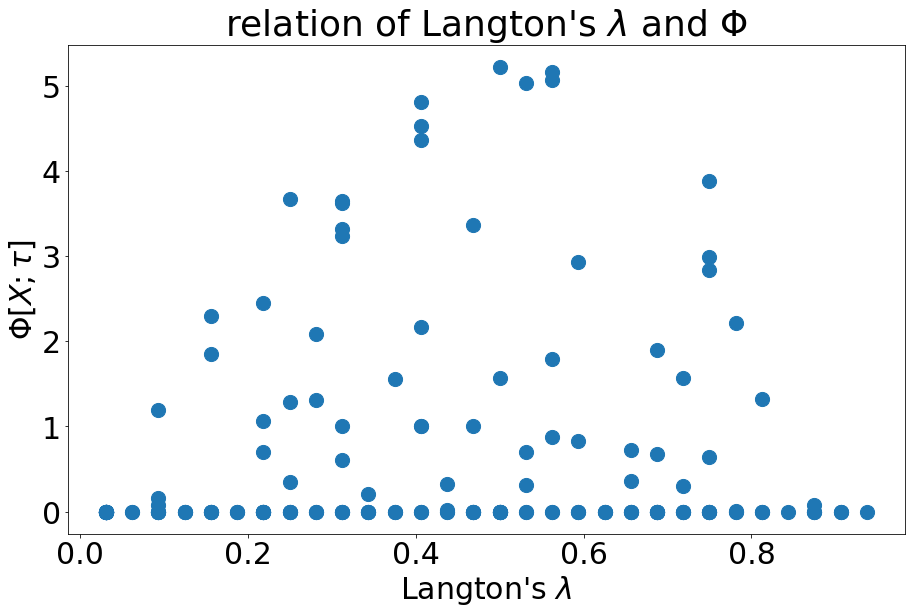

In [43]:
# plot
plt.figure(figsize=[15,9])
plt.rcParams["font.size"] = 30

plt.scatter( lambda_hist , phi_hist,s = 200,label = r'$\phi[ X ; \tau]$')
#plt.scatter( lambda_hist , avmutual_hist,label = r'$\bar{I}$')
#plt.scatter( lambda_hist , aventropy_hist,label = r'$\bar{H}$')
plt.title( "relation of Langton's "+ r"$\lambda$" + " and "+ r"$\Phi$") # + " with " + r"$\tau$ = " +  str(Tau) )
plt.xlabel("Langton's " + r'$\lambda$')
plt.ylabel(r'$\Phi[ X ; \tau ]$')

# **Local Mutual information**

As expected, TE is high in gliders (moving particles), while
excess entropy is high in blinkers (static particles), confirming
Lizier’s results that these structures perform information transfer
and storage in CA.31 More interestingly for our purposes is that 8
is high in all of them—gliders, blinkers, and the collisions between
them.